In [1]:
import BenchmarkTools: @btime, @benchmark;

import Pkg: activate, build
activate("../GSHEIntegrator/.")

using GSHEIntegrator

import Plots
using LaTeXStrings
using Measures
using NPZ
using EllipsisNotation

  Activating project at `~/code/GSHE/GSHEIntegrator`
┌ Info: Precompiling GSHEIntegrator [95376d2f-314f-47c4-97a6-da6eee6a3a26]
└ @ Base loading.jl:1423


In [2]:
using Dates

function generate_filename(base::String="GSHE", counter::Int=0)
    """
    generate_filename(base::String="trajectory", counter::Int=0)

    Generate a unique filename based on the current date and time.

    # Arguments
    - `base::String="trajectory"`: The base name for the file.
    - `counter::Int=0`: Counter to append to the filename if a file with the same name already exists.

    # Returns
    - `String`: A unique filename in the format of `base_date_time[_counter].jld2`

    # Examples
    ```julia
    generate_filename()  # Returns "GSHE_2023_10_03_14_30_00"
    generate_filename("experiment", 1)  # Returns "experiment_2023_10_03_14_30_01"
    """
    date_str = Dates.format(now(), "yyyy_mm_dd")
    time_str = Dates.format(now(), "HH_MM_SS")
    
    filename = "$(base)_$(date_str)_$(time_str)"
    
    # Check if file exists, if yes, append counter
    if isfile("$(filename).jld2") || counter > 0
        filename *= "_$(counter)"
    end
    
    # Increment counter if file with that name exists
    while isfile("$(filename).jld2")
        counter += 1
        filename = "$(base)_$(date_str)_$(time_str)_$(counter)"
    end
    
    return "$(filename)"
end

generate_filename (generic function with 3 methods)

## Load pre-computed data

In [3]:
using JLD2
@load "../data/trajectories/random_trajectories_2023_10_14_19_22_04.jld2"

1-element Vector{Symbol}:
 :results

In [4]:
keys(results[1])

KeySet for a Dict{String, Any} with 14 entries. Keys:
  "r_obs"
  "ϕ_obs"
  "μ"
  "a_kerr"
  "ϕ_src"
  "Δt"
  "Xeps"
  "ϵ0"
  "Xgeo"
  "βLR"
  "θ_obs"
  "r_src"
  "θ_src"
  "β"

In [5]:
# betas = [dict["β"] for dict in results]

data = Dict(
    "r_obs" => [],
    "ϕ_obs" => [],
    "μ" => [],
    "a_kerr" => [],
    "ϕ_src" => [],
    "Δt" => [],
    "Xeps" => [],
    "ϵ0" => [],
    "Xgeo" => [],
    "βLR" => [],
    "θ_obs" => [],
    "r_src" => [],
    "θ_src" => [],
    "β" => []
)

# Populate the arrays in the dictionary
for entry in results
    for key in keys(entry)
        push!(data[key], entry[key])
    end
end

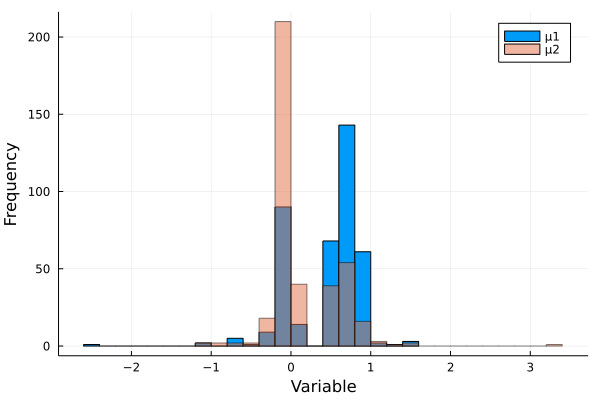

In [13]:
# data[:"μ"][:]
using Plots
gr()

μ1 = Float64[]  # Array for the first component
μ2 = Float64[]  # Array for the second component

for element in data[:"μ"]
    push!(μ1, element[1])
    push!(μ2, element[2])
end

# Now plot the histograms
histogram(μ1, bins=20, label="μ1", xlabel="Variable", ylabel="Frequency")
histogram!(μ2, bins=20, label="μ2", alpha=0.5)  # overlay on the same plot

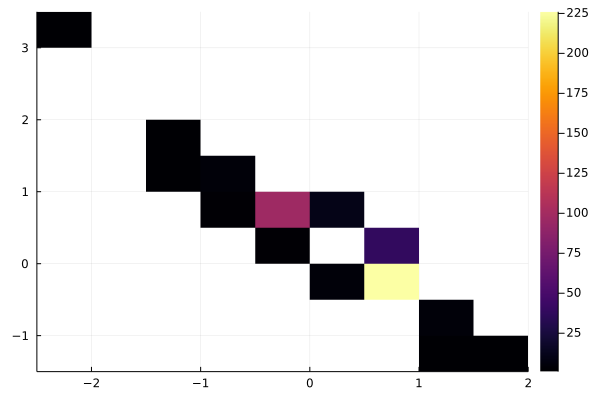

In [14]:
histogram2d(μ1,μ2)

In [ ]:
using Plots
gr()
histogram(data[:"μ"], bins=20, xlabel="Variable", ylabel="Frequency")


## Export to python-friendly format

In [16]:
import Pkg; Pkg.add("FilePathsBase")
import Pkg; Pkg.add("Glob")

   Resolving package versions...
  No Changes to `~/code/GSHE/GSHEIntegrator/Project.toml`
  No Changes to `~/code/GSHE/GSHEIntegrator/Manifest.toml`
   Resolving package versions...
   Installed Glob ─ v1.3.1
    Updating `~/code/GSHE/GSHEIntegrator/Project.toml`
  [c27321d9] + Glob v1.3.1
    Updating `~/code/GSHE/GSHEIntegrator/Manifest.toml`
  [c27321d9] + Glob v1.3.1
Precompiling project...
  ✓ Glob
  ✓ GSHEIntegrator
  2 dependencies successfully precompiled in 381 seconds (317 already precompiled)
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


In [15]:
using HDF5
using JLD2
using FilePathsBase
using FileIO
using Glob

# # Specify your existing JLD2 file path
# input_file_path = "../data/trajectories/random_trajectories_2023_10_14_19_22_04.jld2"



# Specify the directory and file pattern to match
dir_path = "../data/trajectories/"
file_pattern = "random_trajectories_*.jld2"

# Iterate over files matching the pattern
for file_path in glob(joinpath(dir_path, file_pattern))
    # Process each file as needed
    println(file_path)
end

LoadError: ArgumentError: Package Glob not found in current path:
- Run `import Pkg; Pkg.add("Glob")` to install the Glob package.


In [10]:
using HDF5
using JLD2
using FilePathsBase

# Specify your existing JLD2 file path
input_file_path = "../data/trajectories/random_trajectories_2023_10_14_19_22_04.jld2"

# Load your existing JLD2 data
@load input_file_path results

# Derive HDF5 file path from JLD2 file path
output_file_path = replace(input_file_path, ".jld2" => ".h5")

# Create the HDF5 file
h5open(output_file_path, "w") do file
    # Create groups or datasets as needed
    for (i, traj) in enumerate(results)
        grp = create_group(file, "Trajectory_$i")
        for (key, value) in traj
            write(grp, string(key), value)
        end
    end
end


## Compute individual trajectories

Setup the problem geometry

In [3]:
Nsols = 2

# Solve at this many epsilon steps!
ϵs = (10).^LinRange(-3, -1, 10)

geometry = GSHEIntegrator.setup_geometry(
   rsource=5, θsource=0.5π, ϕsource=0.0π,
   robs=25, θobs=0.01π, ϕobs=-π,
   a=0.99,getmagnification=true)

Geometry{Float64}
  dtype: Float64 <: AbstractFloat
  source: SphericalCoords{Float64}
  observer: SphericalCoords{Float64}
  direction_coords: Symbol spherical
  getmagnification: Bool true
  s: Int64 2
  a: Float64 0.99
  arrival_time: Float64 0.0
  redshift: Float64 0.0
  nloops: Float64 0.0
  ϕkilling: Float64 0.0
  ode_options: ODESolverOptions
  opt_options: OptimiserOptions
  postproc_options: PostprocOptions


Solve a geodesic/GSHE trajectory in pointing in an initial direction $\psi=0.2, \rho=0.3$

In [4]:
p0 = [-1, 0.3]
geodesic_sol = GSHEIntegrator.solve_problem(p0, geometry, 0, 2; save_everystep=true)
# GSHE at ϵ=0.1 for s=2
gshe_sol = GSHEIntegrator.solve_problem(p0, geometry, 0.1, 2; save_everystep=true);

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1423


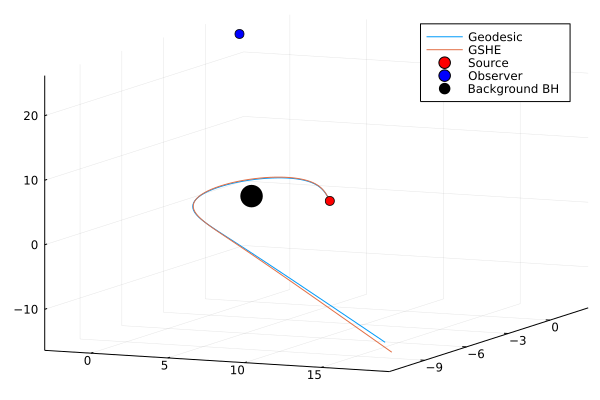

In [5]:
transform(x::Vector{<:Real}) = GSHEIntegrator.spherical_to_cartesian(x, geometry.a)
geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
gshe_trajectory = mapslices(transform, gshe_sol[2:4, :], dims=1)

fig = Plots.plot()
Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic")
Plots.plot!(fig, [gshe_trajectory[i, :] for i in 1:3]..., label="GSHE")

GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)

Arrival timing to the observer

In [6]:
# Each row contains ψ, ρ, t, z, Δσmin, nloops, 
# [init_angle_1, init_angle_2, arrival_time, grav_redshift, optimizer_minimum, nloops, phi_killing, initial_attempt, magnification]
Xgeo = GSHEIntegrator.solve_initial(geometry, 0.0, Nsols)

2×9 Matrix{Float64}:
 1.48947  2.22882  46.3218  1.23836  …  0.0  -0.0919687  1.0  -0.0478902
 1.46868  4.92262  29.0986  1.23836     0.0   0.014864   3.0   0.61644

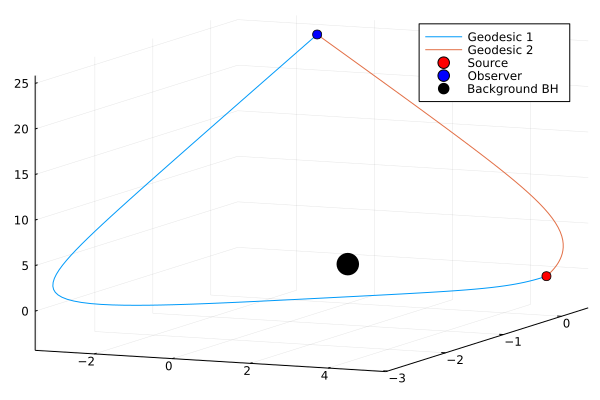

In [7]:
fig = Plots.plot()
for i in 1:2
    geodesic_sol = GSHEIntegrator.solve_problem(Xgeo[i, 1:2], geometry, 0, 2; save_everystep=true)
    geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
    Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic $i")
end
GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)
display(fig)

In [78]:
geodesic_sol = GSHEIntegrator.solve_problem(Xgeo[1, 1:2], geometry, 0, 2)


795/8 774

┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18


retcode: Terminated
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 42.12818348341933
u: 2-element Vector{Vector{Float64}}:
 [0.0, 5.0, 1.5707963267948966, 0.0, -0.7623857648812523, 3.942949615845053, -0.09196872826307669]
 [48.29055320754544, 24.99999999999994, 0.03141592653590595, -3.141592653590241, 0.8250365641312365, -2.751358535873372, -0.09196872826307669]

/8 775/8 776/8 

739/8 740/8 741/8 742/8 743/8 

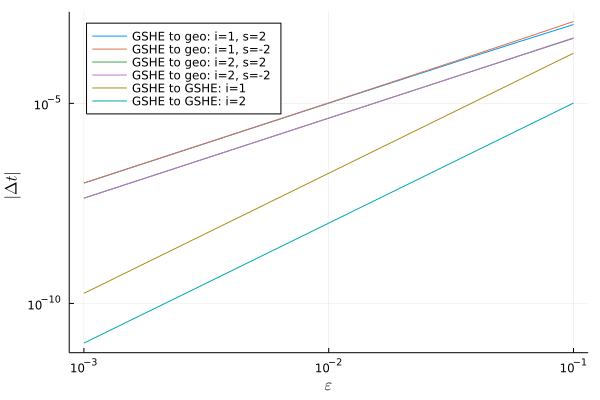

In [53]:
# Each row contains ψ, ρ, t, z, Δσmin, nloops
# Xgeo = GSHEIntegrator.solve_initial(geometry, 0.0, Nsols)
# Shape is  (Nsols, s = ± 2, Nϵs, 6). Last index same as above
Xgshe = GSHEIntegrator.solve_increasing(Xgeo, geometry, ϵs; verbose=false);


fig = Plots.plot(xlabel=L"\epsilon", ylabel=L"|\Delta t|", scale=:log10, yscale=:log10, legend=:topleft)
for i in 1:Nsols, (s, slabel) in enumerate([2, -2])
    dt = abs.(Xgshe[i,  s, :, 3] .- Xgeo[i, 3])
    Plots.plot!(fig, ϵs, dt, label="GSHE to geo: i=$i, s=$slabel")
end

for i in 1:Nsols
    dt = abs.(Xgshe[i,  1, :, 3] .- Xgshe[i, 2, :, 3])
    Plots.plot!(fig, ϵs, dt, label="GSHE to GSHE: i=$i")
end

display(fig)

In [54]:
Xgeo

2×9 Matrix{Float64}:
 1.48947  2.22882  46.3218  1.23836  1.62e-14     0.0  -0.0919687  2.0  NaN
 1.46868  4.92262  29.0986  1.23836  4.27362e-14  0.0   0.014864   1.0  NaN

In [55]:
Xgshe[1,1,1,:]./Xgshe[2,1,1,:]

9-element Vector{Float64}:
   1.0145075761405131
   0.4527089199129495
   1.5918924531934213
   1.0000465157222709
   4.064911697288064
 NaN
  -8.725968658613453
   2.0
 NaN

In [56]:
Xgshe[1,1,1,:]

9-element Vector{Float64}:
   1.4900760915277673
   2.228514473453699
  46.32182146159697
   1.2383879895525614
   1.4164183713178582e-14
   0.0
  -0.09586922475664424
   2.0
 NaN

744/8 745/8 746/8 747/8 748/8 749/8 750/8 741/8 742/8 743/8 744/8 745/8 746/8 747/8 748/8 749/8 750/8 650/8 651/8 652/8 653/8 654/8 655/8 656/8 657/8 658/8 659/8 664/8 665/8 666/8 667/8 668/8 

┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18


669/8 670/8 671/8 672/8 673/8 674/8 675/8 676/8 677/8 678/8 679/8 680/8 681/8 682/8 683/8 684/8 685/8 686/8 687/8 688/8 689/8 690/8 691/8 692/8 693/8 694/8 629/8 630/8 631/8 632/8 633/8 

┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18


In [75]:
using Plots
plotly()
# gr()

fig = Plots.plot()
for i in 1:2
    geodesic_sol = GSHEIntegrator.solve_problem(Xgeo[i, 1:2], geometry, 0, 2; save_everystep=true)
    geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
    Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic $i")
    
    for (j,ϵ) in enumerate(ϵs)
#         println("$i, $ϵ")
        for k in [1,2]
            #put epsilon!
            gshe_sol = GSHEIntegrator.solve_problem(Xgshe[i,k,j, 1:2], 
                geometry, ϵ*(-1)^(k+1), 2; save_everystep=true)
             gshe_trajectory = mapslices(transform, gshe_sol[2:4, :], dims=1)
            Plots.plot!(fig, [gshe_trajectory[i, :] for i in 1:3]...,label=nothing)
        end
    end
   
end
GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)
display(fig)

667/8 668/8 669/8 670/8 671/8 672/8 673/8 674/8 675/8 676/8 677/8 678/8 679/8 680/8 695/8 696/8 697/8 698/8 699/8 700/8 701/8 702/8 703/8 704/8 705/8 706/8 707/8 708/8 709/8 710/8 711/8 712/8 713/8 714/8 715/8 716/8 717/8 718/8 719/8 720/8 721/8 722/8 723/8 724/8 725/8 726/8 727/8 728/8 729/8 730/8 731/8 732/8 733/8 734/8 735/8 736/8 737/8 738/8 739/8 740/8 741/8 742/8 743/8 744/8 745/8 746/8 747/8 748/8 749/8 750/8 651/8 652/8 653/8 654/8 655/8 656/8 657/8 723/8 724/8 725/8 

┌ Warning: Δt = 14.133483995128445 and Δσ = 1.8413592449232012 do not agree
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/solver.jl:30
┌ Warning: Δt = 18.283787703759135 and Δσ = 2.1220571386695637 do not agree
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/solver.jl:30


726/8 727/8 728/8 729/8 730/8 731/8 732/8 681/8 682/8 683/8 684/8 685/8 686/8 687/8 688/8 689/8 690/8 691/8 658/8 659/8 660/8 661/8 733/8 734/8 735/8 692/8 693/8 694/8 695/8 662/8 663/8 664/8 665/8 666/8 667/8 668/8 669/8 670/8 736/8 696/8 697/8 698/8 699/8 700/8 701/8 702/8 703/8 704/8 705/8 706/8 707/8 708/8 709/8 710/8 711/8 712/8 713/8 714/8 715/8 716/8 717/8 718/8 719/8 720/8 721/8 722/8 723/8 724/8 725/8 726/8 727/8 728/8 729/8 730/8 731/8 671/8 672/8 673/8 674/8 675/8 676/8 677/8 678/8 679/8 680/8 681/8 682/8 737/8 738/8 739/8 740/8 

┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Warning: Δt = 19.09157275710043 and Δσ = 0.7721536302611098 do not agree
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/solver.jl:30
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /hom

741/8 742/8 743/8 732/8 733/8 734/8 735/8 736/8 683/8 684/8 685/8 686/8 687/8 688/8 689/8 690/8 691/8 692/8 693/8 694/8 744/8 745/8 746/8 747/8 748/8 749/8 750/8 737/8 738/8 739/8 740/8 741/8 800

┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Warning: Δt = 16.80910715136603 and Δσ = 2.1059086555809006 do not agree
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/solver.jl:30
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18


/8 742/8 743/8 744/8 801/8 745/8 802/8 746/8 803/8 804/8 747/8 748/8 749/8 750/8 695/8 805/8 806/8 696/8 697/8 807/8 698/8 699/8 808/8 700/8 809/8 810/8 811/8 701/8 812/8 702/8 813/8 703/8 814/8 815/8 816/8 704/8 705/8 706/8 707/8 817/8 708/8 818/8 709/8 819/8 820/8 710/8 821/8 711/8 775/8 712/8 776/8 777/8 778/8 779/8 713/8 780/8 766/8 714/8 715/8 767/8 909/8 716/8 717/8 910/8 718/8 911/8 719/8 912/8 913/8 914/8 720/8 721/8 915/8 722/8 723/8 724/8 725/8 726/8 916/8 727/8 917/8 918/8 728/8 919/8 729/8 920/8 730/8 731/8 921/8 732/8 922/8 733/8 923/8 924/8 734/8 925/8 735/8 926/8 927/8 928/8 736/8 929/8 737/8 930/8 931/8 738/8 932/8 933/8 739/8 740/8 934/8 741/8 935/8 742/8 936/8 937/8 743/8 744/8 938/8 939/8 940/8 745/8 941/8 746/8 747/8 942/8 943/8 748/8 749/8 944/8 750/8 945/8 946/8 947/8 948/8 949/8 950/8 951/8 952/8 953/8 954/8 955/8 956/8 957/8 958/8 959/8 960/8 961/8 962/8 963/8 964/8 965/8 966/8 967/8 968/8 969/8 970/8 971/8 972/8 973/8 974/8 975/8 976/8 762/8 763/8 764/8 765/8 7

┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Warning: Δt = 14.02677363572814 and Δσ = 1.5334477065200316 do not agree
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/solver.jl:30
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Warning: Δt = 19.19744468369057 and Δσ = 0.9430201183897278 do not agree
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/solver.jl:30
┌ Info: Initial search terminated with 1/2 solutions.
└ @

981/8 770/8 771/8 772/8 773/8 774/8 775/8 776/8 777/8 778/8 779/8 780/8 781/8 782/8 783/8 845

In [69]:
using Pkg
Pkg.add("PlotlyBase")

721/8 722/8 

   Resolving package versions...
  No Changes to `~/code/GSHE/GSHEIntegrator/Project.toml`
  No Changes to `~/code/GSHE/GSHEIntegrator/Manifest.toml`


In [190]:
# transform(x::Vector{<:Real}) = GSHEIntegrator.spherical_to_cartesian(x, geometry.a)
# geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
# gshe_trajectory = mapslices(transform, gshe_sol[2:4, :], dims=1)

# fig = Plots.plot()
# Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic")
# Plots.plot!(fig, [gshe_trajectory[i, :] for i in 1:3]..., label="GSHE")

In [201]:
αs, βs = GSHEIntegrator.fit_timing(ϵs, Xgeo, Xgshe, geometry; fit_gshe_gshe=true);
println("αs and βs, rows solutions and columns GSHE to GEO, GSHE to GEO and GSHE to GSHE")
flush(stdout)

display(αs[..,1])
display(βs[..,1])

αs and βs, rows solutions and columns GSHE to GEO, GSHE to GEO and GSHE to GSHE


2×3 Matrix{Float64}:
 1.99795  2.00214  2.99506
 1.98457  2.01557  2.9999

2×3 Matrix{Float64}:
 0.0422383  0.0433   0.0099852
 0.0930454  0.11178  0.17918

In [202]:
Xgeo

2×9 Matrix{Float64}:
 1.46868  4.92262  29.0986  1.23836  1.19264e-14  0.0   0.014864   1.0  NaN
 1.48947  2.22882  46.3218  1.23836  2.0466e-14   0.0  -0.0919687  1.0  NaN

In [181]:
filename = "../data/trajectories/"*generate_filename()

using Plots
gr()

fig = Plots.plot()
for i in 1:2
    geodesic_sol = GSHEIntegrator.solve_problem(Xgeo[i, 1:2], geometry, 0, 2; save_everystep=true)
    geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
    Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic $i")
end
GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)

savefig(fig, filename*".png")

using JLD2

@save filename*".jld2" geometry Xgeo Xgshe αs βs

In [316]:
#this would be load like this
@load "../data/trajectories/GSHE_2023_10_03_17_49_14.jld2"
Xgeo
geometry

GSHEIntegrator.Geometry{Float64}
  dtype: Float64 <: AbstractFloat
  source: GSHEIntegrator.SphericalCoords{Float64}
  observer: GSHEIntegrator.SphericalCoords{Float64}
  direction_coords: Symbol spherical
  getmagnification: Bool false
  s: Int64 2
  a: Float64 0.99
  arrival_time: Float64 48.880443355140734
  redshift: Float64 1.2325154676869772
  nloops: Float64 0.0
  ϕkilling: Float64 -1.5897579963070156
  ode_options: GSHEIntegrator.ODESolverOptions
  opt_options: GSHEIntegrator.OptimiserOptions
  postproc_options: GSHEIntegrator.PostprocOptions


## Map the observer positions

In [342]:
ϕs = [1.1π] #collect(range(0.0,stop=2π,length=3))[1:end-1]

# Solve at this many epsilon steps!
ϵs = (10).^LinRange(-3, -1, 10)

Nsols = 2

rsource=5
θsource=0.5π
ϕsource=0
robs=25
θobs=0.5π
ϕobs=-π
akerr=0.99

geometry = GSHEIntegrator.setup_geometry(
   rsource=rsource, θsource=θsource, ϕsource=ϕsource,
   robs=robs, θobs=θobs, ϕobs=ϕobs,
   a=akerr)

GSHEIntegrator.Geometry{Float64}
  dtype: Float64 <: AbstractFloat
  source: GSHEIntegrator.SphericalCoords{Float64}
  observer: GSHEIntegrator.SphericalCoords{Float64}
  direction_coords: Symbol spherical
  getmagnification: Bool false
  s: Int64 2
  a: Float64 0.99
  arrival_time: Float64 0.0
  redshift: Float64 0.0
  nloops: Float64 0.0
  ϕkilling: Float64 0.0
  ode_options: GSHEIntegrator.ODESolverOptions
  opt_options: GSHEIntegrator.OptimiserOptions
  postproc_options: GSHEIntegrator.PostprocOptions


In [343]:
#compute only 2 trajectories and infer beta, betaLR from them
ϵ0 = 1e-3

for ϕ in ϕs
    geometry = GSHEIntegrator.setup_geometry(
       rsource=rsource, θsource=θsource, ϕsource=ϕsource,
       robs=robs, θobs=θobs, ϕobs=ϕ,
       a=akerr)
    # Each row contains ψ, ρ, t, z, Δσmin, nloops
    Xgeo = GSHEIntegrator.solve_initial(geometry, 0.0, Nsols)
    # Shape is  (Nsols, s = ± 2, Nϵs, 6). Last index same as above
    Xeps = GSHEIntegrator.solve_initial(geometry, ϵ0, Nsols)
    println("ϕ   =",ϕ)
    println("μ   =",Xgeo[:,7])
    println("Δt  = ",Xgeo[2,3]-Xgeo[1,3])
    println("β   =",(Xgeo[:,3]-Xeps[:,1,3])/ϵ0^2)
    println("βLR =",(Xeps[:,1,3]-Xeps[:,2,3])/ϵ0^3)
end

ϕ   =3.455751918948773
μ   =[-5.618309113374083, -3.1200141575238916]
Δt  = 0.0042449907933459485
β   =[-71.54310382162521, 45.5196501292221]
βLR =[-4.127928039395101e6, -6811.691477537352]


┌ Warning: Δt = 0.0020673698654363193 and Δσ = 1.3924529140926416 do not agree
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/solver.jl:30


In [344]:
Xgeo

2×9 Matrix{Float64}:
 2.99722  3.14159  38.3189  1.23828  3.71249e-14  0.0  -5.61831  1.0  NaN
 2.10076  1.89544  38.3232  1.23828  9.10888e-15  0.0  -3.12001  1.0  NaN

In [364]:
fig = Plots.plot()
for i in 1:2
    geodesic_sol = GSHEIntegrator.solve_problem(Xgeo[i, 1:2], geometry, 0, 2; save_everystep=true)
    geodesic_trajectory = mapslices(transform, geodesic_sol[2:4, :], dims=1)
    Plots.plot!(fig, [geodesic_trajectory[i, :] for i in 1:3]..., label="Geodesic $i")
end
#plot the BH spin
plot!(fig, [0, 0], [0, 0], [0, 1.5], arrow=(2, 3, :open), linewidth=4, linecolor=:black, label=nothing)
GSHEIntegrator.plot_start_end!(fig, geometry)
GSHEIntegrator.plotbh!(fig)
display(fig)

## Test the random sampling, with magnification

In [7]:
using Random

Nsols = 2 

rsource=5
θsource=0.5π
ϕsource=0
robs=25
θobs=0.5π
ϕobs=-π
akerr=0.99
ϵ0=1e-3 


θsrc = acos(1 - 2 * rand())
θobs = acos(1 - 2 * rand())
ϕobs = 2 * pi * rand()

# compute magnification only on the GO trajectory
geometry = GSHEIntegrator.setup_geometry(
   rsource=rsource, θsource=θsrc, ϕsource=0,
   robs=robs, θobs=θobs, ϕobs=ϕobs,
   a=akerr,getmagnification=true)

Xgeo = GSHEIntegrator.solve_initial(geometry, 0.0, Nsols)


geometry_no_mag = GSHEIntegrator.setup_geometry(
    rsource=rsource, θsource=θsrc, ϕsource=0,
    robs=robs, θobs=θobs, ϕobs=ϕobs,
    a=akerr, getmagnification=false)

Xeps = GSHEIntegrator.solve_initial(geometry_no_mag, ϵ0, Nsols)


# Create a dictionary to store the results of this iteration
result = Dict(
    "θ_src" => θsrc,
    "ϕ_src" => 0,
    "θ_obs" => θobs,
    "ϕ_obs" => ϕobs,
    "r_src" => rsource,
    "r_obs" => robs,
    "Xgeo" => Xgeo,
    "Xeps" => Xeps,
    "μ" => Xgeo[:,9],
    "Δt" => Xgeo[2,3] - Xgeo[1,3],
    "β" => (Xgeo[:,3] - Xeps[:,1,3]) / ϵ0^2,
    "βLR" => (Xeps[:,1,3] - Xeps[:,2,3]) / ϵ0^3,
    "ϵ0" => ϵ0,
    "a_kerr" => akerr,
    # ... add other quantities here
)
print(result)

Dict{String, Any}("r_obs" => 25, "ϕ_obs" => 6.1541656366985515, "μ" => [0.6662561000007091, -0.044270867452868234], "Xeps" => [1.2604520039357079 1.7417120724585857; 1.5412074903197328 1.541041608284923;;; 2.3914053156232242 4.097344283311727; 5.0852499016543815 5.085249926930493;;; 46.626610227026816 62.924697644306804; 27.71835435795319 27.718354357963346;;; 1.2380299982974463 1.238026061347724; 1.237970978282351 1.2380372330209033;;; 6.408823860530842e-15 1.1861361466183393e-13; 1.9709082319208406e-14 6.338948245218559e-14;;; 0.0 1.0; 0.0 0.0;;; 1.0578318278188845 -1.3715957826141716; -0.35193834286335596 -0.35245263730641346;;; 4.0 8.0; 2.0 2.0;;; NaN NaN; NaN NaN], "ϵ0" => 0.001, "Xgeo" => [1.5411245536550773 5.085249914815572 27.718354325096552 1.2380041014540744 3.734990880217121e-15 0.0 -0.3482427648207742 1.0 0.6662561000007091; 1.2598735691898455 2.391922903639116 46.626609842192714 1.238004101454072 1.0751118031574307e-14 0.0 1.0616688100921847 2.0 -0.044270867452868234], "a

In [12]:
print(result[:"μ"])

[0.6662561000007091, -0.044270867452868234]

## Sample randomly observer and source positions

In [8]:
using Random

Nsols = 2 


rsource=5
θsource=0.5π
ϕsource=0
robs=25
θobs=0.5π
ϕobs=-π
akerr=0.99
ϵ0=1e-3 

n_points = 2

print(n_points)


2

**NOTE**

Define name at the beginning of the run and store data periodically

In [86]:
using Random

#use a file_lock to avoid problems
file_lock = ReentrantLock()

# Initialize an array of Dicts to store the results for each iteration
results = []

# Save the partial results array to a JLD2 or HDF5 file
using JLD2
generate_filename()
filename = "../data/trajectories/"*generate_filename("random_trajectories")
print(filename)

# for i in 1:n_points
Threads.@threads for i in 1:n_points
    θsrc = acos(1 - 2 * rand())
    θobs = acos(1 - 2 * rand())
    ϕobs = 2 * pi * rand()
    
    # Your existing code to set up geometry and solve...
    geometry = GSHEIntegrator.setup_geometry(
       rsource=rsource, θsource=θsrc, ϕsource=0,
       robs=robs, θobs=θobs, ϕobs=ϕobs,
       a=akerr,getmagnification=true)
    
    Xgeo = GSHEIntegrator.solve_initial(geometry_no_mag, 0.0, Nsols)
    
    geometry_no_mag = GSHEIntegrator.setup_geometry(
        rsource=rsource, θsource=θsrc, ϕsource=0,
        robs=robs, θobs=θobs, ϕobs=ϕobs,
        a=akerr, getmagnification=false)
    
    
    Xeps = GSHEIntegrator.solve_initial(geometry_no_mag, ϵ0, Nsols)
    
    
    # Create a dictionary to store the results of this iteration
    result = Dict(
        "θ_src" => θsrc,
        "ϕ_src" => 0,
        "θ_obs" => θobs,
        "ϕ_obs" => ϕobs,
        "r_src" => rsource,
        "r_obs" => robs,
        "Xgeo" => Xgeo,
        "Xeps" => Xeps,
        "μ" => Xgeo[:,9],
        "Δt" => Xgeo[2,3] - Xgeo[1,3],
        "β" => (Xgeo[:,3] - Xeps[:,1,3]) / ϵ0^2,
        "βLR" => (Xeps[:,1,3] - Xeps[:,2,3]) / ϵ0^3,
        "ϵ0" => ϵ0,
        "a_kerr" => akerr,
        # ... add other quantities here
    )
    print(i,"/",n_points," ")
    
    # Add this dictionary to the results array
    push!(results, result)
    
    # Lock the file for writing
    lock(file_lock)
    
    try
        @save filename*".jld2" results
    finally
        # Release the lock
        unlock(file_lock)
    end
end


../data/trajectories/random_trajectories_2023_10_10_15_46_01789

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
      [1] [0m[1m(::GSHEIntegrator.var"#odes!#35"{Int64})[22m[0m[1m([22m[90mdx[39m::[0mVector[90m{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}[39m, [90mx[39m::[0mVector[90m{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}[39m, [90mgeometry[39m::[0mGeometry[90m{Float64}[39m, [90mtau[39m::[0mForwardDiff.Dual[90m{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}[39m[0m[1m)[22m
    [90m    @ [39m[35mGSHEIntegrator[39m [90m~/code/GSHE/GSHEIntegrator/src/[39m[90m[4mintegrator.jl:468[24m[39m
      [2] [0m[1mODEFunction[22m
    [90m    @ [39m[90m~/.julia/packages/SciMLBase/GW7GW/src/[39m[90m[4mscimlfunctions.jl:345[24m[39m[90m [inlined][39m
      [3] [0m[1mode_determine_initdt[22m[0m[1m([22m[90mu0[39m::[0mVector[90m{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}[39m, [90mt[39m::[0mForwardDiff.Dual[90m{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}[39m, [90mtdir[39m::[0mForwardDiff.Dual[90m{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}[39m, [90mdtmax[39m::[0mForwardDiff.Dual[90m{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}[39m, [90mabstol[39m::[0mFloat64, [90mreltol[39m::[0mFloat64, [90minternalnorm[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_NORM), [90mprob[39m::[0mSciMLBase.ODEProblem[90m{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Tuple{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, true, Geometry{Float64}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, [90mintegrator[39m::[0mOrdinaryDiffEq.ODEIntegrator[90m{OrdinaryDiffEq.Vern9, true, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Nothing, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Geometry{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Float64, Float64, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}, SciMLBase.ODESolution{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, 2, Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}, Nothing, Nothing, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}}, SciMLBase.ODEProblem{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Tuple{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, true, Geometry{Float64}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, OrdinaryDiffEq.Vern9, OrdinaryDiffEq.InterpolationData{SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}}, OrdinaryDiffEq.Vern9Cache{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}}, DiffEqBase.DEStats}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, OrdinaryDiffEq.Vern9Cache{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, OrdinaryDiffEq.PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, SciMLBase.CallbackSet{Tuple{SciMLBase.ContinuousCallback{GSHEIntegrator.var"#f#18"{Geometry{Float64}}, GSHEIntegrator.var"#terminate_affect!#19", GSHEIntegrator.var"#terminate_affect!#19", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Int64, Int64}}, Tuple{SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#20"{Float64}, GSHEIntegrator.var"#terminate_affect!#21", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#22"{Float64, Float64}, GSHEIntegrator.var"#terminate_affect!#23", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, DataStructures.FasterForward}, DataStructures.BinaryHeap{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Nothing, OrdinaryDiffEq.DefaultInit}[39m[0m[1m)[22m
    [90m    @ [39m[36mOrdinaryDiffEq[39m [90m~/.julia/packages/OrdinaryDiffEq/iN7BJ/src/[39m[90m[4minitdt.jl:49[24m[39m
      [4] [0m[1mauto_dt_reset![22m[0m[1m([22m[90mintegrator[39m::[0mOrdinaryDiffEq.ODEIntegrator[90m{OrdinaryDiffEq.Vern9, true, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Nothing, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Geometry{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Float64, Float64, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}, SciMLBase.ODESolution{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, 2, Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}, Nothing, Nothing, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}}, SciMLBase.ODEProblem{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Tuple{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, true, Geometry{Float64}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, OrdinaryDiffEq.Vern9, OrdinaryDiffEq.InterpolationData{SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}}, OrdinaryDiffEq.Vern9Cache{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}}, DiffEqBase.DEStats}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, OrdinaryDiffEq.Vern9Cache{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, OrdinaryDiffEq.PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, SciMLBase.CallbackSet{Tuple{SciMLBase.ContinuousCallback{GSHEIntegrator.var"#f#18"{Geometry{Float64}}, GSHEIntegrator.var"#terminate_affect!#19", GSHEIntegrator.var"#terminate_affect!#19", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Int64, Int64}}, Tuple{SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#20"{Float64}, GSHEIntegrator.var"#terminate_affect!#21", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#22"{Float64, Float64}, GSHEIntegrator.var"#terminate_affect!#23", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, DataStructures.FasterForward}, DataStructures.BinaryHeap{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Nothing, OrdinaryDiffEq.DefaultInit}[39m[0m[1m)[22m
    [90m    @ [39m[36mOrdinaryDiffEq[39m [90m~/.julia/packages/OrdinaryDiffEq/iN7BJ/src/integrators/[39m[90m[4mintegrator_interface.jl:346[24m[39m
      [5] [0m[1mhandle_dt![22m[0m[1m([22m[90mintegrator[39m::[0mOrdinaryDiffEq.ODEIntegrator[90m{OrdinaryDiffEq.Vern9, true, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Nothing, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Geometry{Float64}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Float64, Float64, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}, SciMLBase.ODESolution{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, 2, Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}, Nothing, Nothing, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}}, SciMLBase.ODEProblem{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Tuple{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, true, Geometry{Float64}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, OrdinaryDiffEq.Vern9, OrdinaryDiffEq.InterpolationData{SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{Vector{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}}, OrdinaryDiffEq.Vern9Cache{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}}, DiffEqBase.DEStats}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, OrdinaryDiffEq.Vern9Cache{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, OrdinaryDiffEq.Vern9Tableau{Float64, Float64}}, OrdinaryDiffEq.DEOptions{Float64, Float64, Float64, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, OrdinaryDiffEq.PIController{Rational{Int64}}, typeof(DiffEqBase.ODE_DEFAULT_NORM), typeof(LinearAlgebra.opnorm), Nothing, SciMLBase.CallbackSet{Tuple{SciMLBase.ContinuousCallback{GSHEIntegrator.var"#f#18"{Geometry{Float64}}, GSHEIntegrator.var"#terminate_affect!#19", GSHEIntegrator.var"#terminate_affect!#19", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Int64, Int64}}, Tuple{SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#20"{Float64}, GSHEIntegrator.var"#terminate_affect!#21", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#22"{Float64, Float64}, GSHEIntegrator.var"#terminate_affect!#23", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), DataStructures.BinaryHeap{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, DataStructures.FasterForward}, DataStructures.BinaryHeap{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, DataStructures.FasterForward}, Nothing, Nothing, Int64, Tuple{}, Tuple{}, Tuple{}}, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, Nothing, OrdinaryDiffEq.DefaultInit}[39m[0m[1m)[22m
    [90m    @ [39m[36mOrdinaryDiffEq[39m [90m~/.julia/packages/OrdinaryDiffEq/iN7BJ/src/[39m[90m[4msolve.jl:504[24m[39m
      [6] [0m[1m__init[22m[0m[1m([22m[90mprob[39m::[0mSciMLBase.ODEProblem[90m{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Tuple{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, true, Geometry{Float64}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, [90malg[39m::[0mOrdinaryDiffEq.Vern9, [90mtimeseries_init[39m::[0mTuple[90m{}[39m, [90mts_init[39m::[0mTuple[90m{}[39m, [90mks_init[39m::[0mTuple[90m{}[39m, [90mrecompile[39m::[0mType[90m{Val{true}}[39m; [90msaveat[39m::[0mTuple[90m{}[39m, [90mtstops[39m::[0mTuple[90m{}[39m, [90md_discontinuities[39m::[0mTuple[90m{}[39m, [90msave_idxs[39m::[0mNothing, [90msave_everystep[39m::[0mBool, [90msave_on[39m::[0mBool, [90msave_start[39m::[0mBool, [90msave_end[39m::[0mNothing, [90mcallback[39m::[0mSciMLBase.CallbackSet[90m{Tuple{SciMLBase.ContinuousCallback{GSHEIntegrator.var"#f#18"{Geometry{Float64}}, GSHEIntegrator.var"#terminate_affect!#19", GSHEIntegrator.var"#terminate_affect!#19", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Int64, Int64}}, Tuple{SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#20"{Float64}, GSHEIntegrator.var"#terminate_affect!#21", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#22"{Float64, Float64}, GSHEIntegrator.var"#terminate_affect!#23", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}[39m, [90mdense[39m::[0mBool, [90mcalck[39m::[0mBool, [90mdt[39m::[0mForwardDiff.Dual[90m{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}[39m, [90mdtmin[39m::[0mNothing, [90mdtmax[39m::[0mForwardDiff.Dual[90m{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}[39m, [90mforce_dtmin[39m::[0mBool, [90madaptive[39m::[0mBool, [90mgamma[39m::[0mRational[90m{Int64}[39m, [90mabstol[39m::[0mFloat64, [90mreltol[39m::[0mFloat64, [90mqmin[39m::[0mRational[90m{Int64}[39m, [90mqmax[39m::[0mInt64, [90mqsteady_min[39m::[0mInt64, [90mqsteady_max[39m::[0mInt64, [90mbeta1[39m::[0mNothing, [90mbeta2[39m::[0mNothing, [90mqoldinit[39m::[0mRational[90m{Int64}[39m, [90mcontroller[39m::[0mNothing, [90mfullnormalize[39m::[0mBool, [90mfailfactor[39m::[0mInt64, [90mmaxiters[39m::[0mInt64, [90minternalnorm[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_NORM), [90minternalopnorm[39m::[0mtypeof(LinearAlgebra.opnorm), [90misoutofdomain[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN), [90munstable_check[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK), [90mverbose[39m::[0mBool, [90mtimeseries_errors[39m::[0mBool, [90mdense_errors[39m::[0mBool, [90madvance_to_tstop[39m::[0mBool, [90mstop_at_next_tstop[39m::[0mBool, [90minitialize_save[39m::[0mBool, [90mprogress[39m::[0mBool, [90mprogress_steps[39m::[0mInt64, [90mprogress_name[39m::[0mString, [90mprogress_message[39m::[0mtypeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE), [90muserdata[39m::[0mNothing, [90mallow_extrapolation[39m::[0mBool, [90minitialize_integrator[39m::[0mBool, [90malias_u0[39m::[0mBool, [90malias_du0[39m::[0mBool, [90minitializealg[39m::[0mOrdinaryDiffEq.DefaultInit, [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
    [90m    @ [39m[36mOrdinaryDiffEq[39m [90m~/.julia/packages/OrdinaryDiffEq/iN7BJ/src/[39m[90m[4msolve.jl:466[24m[39m
      [7] [0m[1m__solve[22m[0m[1m([22m::[0mSciMLBase.ODEProblem[90m{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Tuple{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}, ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, true, Geometry{Float64}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, ::[0mOrdinaryDiffEq.Vern9; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Any, NTuple{6, Symbol}, NamedTuple{(:callback, :save_everystep, :reltol, :abstol, :maxiters, :verbose), Tuple{SciMLBase.CallbackSet{Tuple{SciMLBase.ContinuousCallback{GSHEIntegrator.var"#f#18"{Geometry{Float64}}, GSHEIntegrator.var"#terminate_affect!#19", GSHEIntegrator.var"#terminate_affect!#19", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Int64, Int64}}, Tuple{SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#20"{Float64}, GSHEIntegrator.var"#terminate_affect!#21", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#22"{Float64, Float64}, GSHEIntegrator.var"#terminate_affect!#23", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, Bool, Float64, Float64, Int64, Bool}}}[39m[0m[1m)[22m
    [90m    @ [39m[36mOrdinaryDiffEq[39m [90m~/.julia/packages/OrdinaryDiffEq/iN7BJ/src/[39m[90m[4msolve.jl:4[24m[39m
      [8] [0m[1m#solve_call#37[22m
    [90m    @ [39m[90m~/.julia/packages/DiffEqBase/aELvu/src/[39m[90m[4msolve.jl:61[24m[39m[90m [inlined][39m
      [9] [0m[1msolve_up[22m[0m[1m([22m[90mprob[39m::[0mSciMLBase.ODEProblem[90m{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Tuple{Float64, Float64}, true, Geometry{Float64}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, [90msensealg[39m::[0mNothing, [90mu0[39m::[0mVector[90m{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}[39m, [90mp[39m::[0mGeometry[90m{Float64}[39m, [90margs[39m::[0mOrdinaryDiffEq.Vern9; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Any, NTuple{6, Symbol}, NamedTuple{(:callback, :save_everystep, :reltol, :abstol, :maxiters, :verbose), Tuple{SciMLBase.CallbackSet{Tuple{SciMLBase.ContinuousCallback{GSHEIntegrator.var"#f#18"{Geometry{Float64}}, GSHEIntegrator.var"#terminate_affect!#19", GSHEIntegrator.var"#terminate_affect!#19", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Int64, Int64}}, Tuple{SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#20"{Float64}, GSHEIntegrator.var"#terminate_affect!#21", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#22"{Float64, Float64}, GSHEIntegrator.var"#terminate_affect!#23", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}, Bool, Float64, Float64, Int64, Bool}}}[39m[0m[1m)[22m
    [90m    @ [39m[32mDiffEqBase[39m [90m~/.julia/packages/DiffEqBase/aELvu/src/[39m[90m[4msolve.jl:87[24m[39m
     [10] [0m[1m#solve#38[22m
    [90m    @ [39m[90m~/.julia/packages/DiffEqBase/aELvu/src/[39m[90m[4msolve.jl:73[24m[39m[90m [inlined][39m
     [11] [0m[1msolve_problem[22m[0m[1m([22m[90mprob[39m::[0mSciMLBase.ODEProblem[90m{Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}, Tuple{Float64, Float64}, true, Geometry{Float64}, SciMLBase.ODEFunction{true, GSHEIntegrator.var"#odes!#35"{Int64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}[39m, [90mgeometry[39m::[0mGeometry[90m{Float64}[39m, [90mcb[39m::[0mSciMLBase.CallbackSet[90m{Tuple{SciMLBase.ContinuousCallback{GSHEIntegrator.var"#f#18"{Geometry{Float64}}, GSHEIntegrator.var"#terminate_affect!#19", GSHEIntegrator.var"#terminate_affect!#19", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Int64, Int64}}, Tuple{SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#20"{Float64}, GSHEIntegrator.var"#terminate_affect!#21", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}, SciMLBase.DiscreteCallback{GSHEIntegrator.var"#f#22"{Float64, Float64}, GSHEIntegrator.var"#terminate_affect!#23", typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}}}[39m; [90msave_everystep[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mGSHEIntegrator[39m [90m~/code/GSHE/GSHEIntegrator/src/[39m[90m[4mintegrator.jl:149[24m[39m
     [12] [0m[1msolve_problem[22m[0m[1m([22m[90minit_direction[39m::[0mVector[90m{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}[39m, [90mgeometry[39m::[0mGeometry[90m{Float64}[39m, [90mϵ[39m::[0mFloat64, [90ms[39m::[0mInt64; [90msave_everystep[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mGSHEIntegrator[39m [90m~/code/GSHE/GSHEIntegrator/src/[39m[90m[4mintegrator.jl:196[24m[39m
     [13] [0m[1msolve_problem[22m
    [90m    @ [39m[90m~/code/GSHE/GSHEIntegrator/src/[39m[90m[4mintegrator.jl:195[24m[39m[90m [inlined][39m
     [14] [0m[1m(::GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64})[22m[0m[1m([22m[90mx[39m::[0mVector[90m{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}[39m[0m[1m)[22m
    [90m    @ [39m[35mGSHEIntegrator[39m [90m~/code/GSHE/GSHEIntegrator/src/[39m[90m[4mintegrator.jl:498[24m[39m
     [15] [0m[1mvector_mode_dual_eval![22m
    [90m    @ [39m[90m~/.julia/packages/ForwardDiff/wAaVJ/src/[39m[90m[4mapiutils.jl:37[24m[39m[90m [inlined][39m
     [16] [0m[1mvector_mode_jacobian[22m[0m[1m([22m[90mf[39m::[0mGSHEIntegrator.var"#f#36"[90m{Geometry{Float64}, Float64, Int64}[39m, [90mx[39m::[0mVector[90m{Float64}[39m, [90mcfg[39m::[0mForwardDiff.JacobianConfig[90m{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}[39m[0m[1m)[22m
    [90m    @ [39m[33mForwardDiff[39m [90m~/.julia/packages/ForwardDiff/wAaVJ/src/[39m[90m[4mjacobian.jl:148[24m[39m
     [17] [0m[1mjacobian[22m[0m[1m([22m[90mf[39m::[0mFunction, [90mx[39m::[0mVector[90m{Float64}[39m, [90mcfg[39m::[0mForwardDiff.JacobianConfig[90m{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}[39m, ::[0mVal[90m{true}[39m[0m[1m)[22m
    [90m    @ [39m[33mForwardDiff[39m [90m~/.julia/packages/ForwardDiff/wAaVJ/src/[39m[90m[4mjacobian.jl:21[24m[39m
     [18] [0m[1mjacobian[22m[0m[1m([22m[90mf[39m::[0mFunction, [90mx[39m::[0mVector[90m{Float64}[39m, [90mcfg[39m::[0mForwardDiff.JacobianConfig[90m{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2, Vector{ForwardDiff.Dual{ForwardDiff.Tag{GSHEIntegrator.var"#f#36"{Geometry{Float64}, Float64, Int64}, Float64}, Float64, 2}}}[39m[0m[1m)[22m[90m (repeats 2 times)[39m
    [90m    @ [39m[33mForwardDiff[39m [90m~/.julia/packages/ForwardDiff/wAaVJ/src/[39m[90m[4mjacobian.jl:19[24m[39m
     [19] [0m[1mmagnification[22m[0m[1m([22m[90mdir[39m::[0mVector[90m{Float64}[39m, [90mgeometry[39m::[0mGeometry[90m{Float64}[39m, [90mϵ[39m::[0mFloat64, [90ms[39m::[0mInt64, [90mfromshadow[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mGSHEIntegrator[39m [90m~/code/GSHE/GSHEIntegrator/src/[39m[90m[4mintegrator.jl:507[24m[39m
     [20] [0m[1mfind_initial_minima[22m[0m[1m([22m[90mgeometry[39m::[0mGeometry[90m{Float64}[39m, [90mϵ[39m::[0mFloat64, [90ms[39m::[0mInt64, [90mNsols[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[35mGSHEIntegrator[39m [90m~/code/GSHE/GSHEIntegrator/src/[39m[90m[4mminimas.jl:28[24m[39m
     [21] [0m[1msolve_initial[22m[0m[1m([22m[90mgeometry[39m::[0mGeometry[90m{Float64}[39m, [90mϵ[39m::[0mFloat64, [90mNsols[39m::[0mInt64[0m[1m)[22m
    [90m    @ [39m[35mGSHEIntegrator[39m [90m~/code/GSHE/GSHEIntegrator/src/[39m[90m[4msolver.jl:9[24m[39m
     [22] [0m[1mmacro expansion[22m
    [90m    @ [39m[90m./[39m[90m[4mIn[86]:28[24m[39m[90m [inlined][39m
     [23] [0m[1m(::var"#306#threadsfor_fun#69"{UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:85[24m[39m
     [24] [0m[1m(::var"#306#threadsfor_fun#69"{UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @ [39m[35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:52[24m[39m

In [39]:
# Save the partial results array to a JLD2 or HDF5 file
using JLD2
# generate_filename()
# filename = "../data/trajectories/"*generate_filename("random_trajectories")
print(filename)
@save filename*".jld2" results

../data/trajectories/random_trajectories_2023_10_07_15_16_54

LoadError: ArgumentError: attempted to truncate a file that was already open

875/1000 265/1000 517/1000 876/1000 518/1000 877/1000 519/1000 266/1000 520/1000 267/1000 878/1000 521/1000 542/1000 268/1000 879/1000 269/1000 880/1000 543/1000 881/1000 544/1000 882/1000 270/1000 883/1000 884/1000 545/1000 271/1000 885/1000 546/1000 886/1000 272/1000 547/1000 548/1000 273/1000 887/1000 549/1000 888/1000 274/1000 889/1000 275/1000 550/1000 276/1000 551/1000 277/1000 552/1000 253/1000 553/1000 254/1000 554/1000 527/1000 255/1000 256/1000 528/1000 257/1000 529/1000 530/1000 258/1000 259/1000 531/1000 532/1000 533/1000 534/1000 535/1000 260/1000 536/1000 261/1000 537/1000 262/1000 538/1000 539/1000 263/1000 264/1000 540/1000 265/1000 541/1000 266/1000 542/1000 267/1000 543/1000 268/1000 269/1000 544/1000 545/1000 270/1000 546/1000 271/1000 547/1000 272/1000 548/1000 549/1000 550/1000 273/1000 553/1000 554/1000 274/1000 529/1000 275/1000 530/1000 276/1000 531/1000 277/1000 555/1000 278/1000 279/1000 280/1000 556/1000 557/1000 281/1000 558/1000 282/1000 559/1000 560/1000 2

┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Info: Initial search terminated with 1/2 solutions.
└ @ GSHEIntegrator /home/miguel/code/GSHE/GSHEIntegrator/src/minimas.jl:18
┌ Warning: Δt = 33.28803538346841 and Δσ = 1.8883751255270296 do not agree
└ @ GSHEIntegrator /ho

537/1000 294/1000 295/1000 538/1000 539/1000 296/1000 540/1000 297/1000 541/1000 298/1000 542/1000 543/1000 301/1000 544/1000 545/1000 302/1000 546/1000 303/1000 547/1000 304/1000 305/1000 548/1000 306/1000 549/1000 307/1000 550/1000 308/1000 551/1000 309/1000 310/1000 583/1000 311/1000 312/1000 584/1000 585/1000 313/1000 586/1000 314/1000 587/1000 315/1000 588/1000 316/1000 589/1000 590/1000 317/1000 318/1000 558/1000 319/1000 320/1000 559/1000 321/1000 560/1000 322/1000 561/1000 564

In [28]:
Threads.nthreads()
results

9-element Vector{Any}:
 Dict{String, Any}("ϕ_obs" => 2.7708763362109283, "μ" => [1.9289290102464733, -3.2124096413511585], "Xeps" => [1.053725988474954 1.0535268219201537; 2.1892251630548785 2.188074102364185;;; 4.591622290872669 4.591581208775735; 2.0900098836333436 2.0899336290043884;;; 31.77254526959161 31.77254526959218; 45.67412153266386 45.67412153270318;;; 1.2360952982972226 1.2361509915771445; 1.23613627203533 1.2361099981128385;;; 2.909673923553553e-14 2.0255892344537596e-14; 5.003092855319065e-14 2.3996206638962452e-14;;; 0.0 0.0; 0.0 0.0;;; 1.9265488570669747 1.9280349288801562; -3.214706231021269 -3.215583930914466;;; 1.0 1.0; 2.0 1.0;;; NaN NaN; NaN NaN], "ϵ0" => 0.001, "Xgeo" => [1.0536264041191286 4.5916017568924765 … 1.0 NaN; 2.1886496575688605 2.0899716018401757 … 4.0 NaN], "a_kerr" => 0.99, "ϕ_src" => 0, "Δt" => 13.901576477037068, "βLR" => [-0.0005684341886080801, -0.039321434996963944], "θ_obs" => 0.9442026139514362…)
 Dict{String, Any}("ϕ_obs" => 2.104085526748435,

In [392]:
@load "../data/trajectories/random_trajectories_2023_10_06_17_22_05.jld2"
results

11-element Vector{Any}:
 Dict{String, Any}("ϕ_obs" => 2.487212656239817, "μ" => [2.393982390785562, -2.79125751919607], "a_kerr" => 0.99, "ϕ_src" => 0, "Δt" => 10.547171095005972, "Xeps" => [2.712254441013554 2.712453556541122; 0.4920691016618958 0.4922583579325848;;; 3.2961681199515924 3.2935386651390948; 2.1643850697838527 2.1640526928153365;;; 43.981500761306194 43.98150076130768; 33.4343299629401 33.434329962940744;;; 1.2277290791347513 1.2276991811578115; 1.2277308617251026 1.2276974213728908;;; 1.2599130567528934e-14 1.3386274123997828e-14; 1.6700684911328236e-14 3.7784816266239055e-14;;; 0.0 0.0; 0.0 0.0;;; -2.792276654184281 -2.791821055615558; 2.3929390880721506 2.3907402659934474;;; 1.0 1.0; 1.0 1.0;;; NaN NaN; NaN NaN], "ϵ0" => 0.001, "Xgeo" => [0.49216371852905083 2.1642188408560923 … 1.0 NaN; 2.712354435442421 3.294853670785548 … 3.0 NaN], "βLR" => [-0.0014850343177386094, -0.0006465938895416912], "θ_obs" => 1.1837158498626261…)
 Dict{String, Any}("ϕ_obs" => 0.244502689904

In [390]:
using JLD2

#combine with previous
file_path = "../data/all_random_trajectories.jld2"
if isfile(file_path)
    # File exists, open in read-write mode
    jldopen(file_path, "r+") do file
        existing_results = file["results"]
        results = vcat(existing_results, results)  # Combine old and new results
        file["results"] = results
    end
else
    # File doesn't exist, just save it
    @save file_path results
end

LoadError: UndefVarError: results not defined

### Attempt to use Healpix

In [272]:
# using Healpix
# using Plots

# function plot_healpix(nside)
#     npix = nside2npix(nside)
#     θ, φ = hpind2ang(nside, 1:npix)
    
#     # Convert to Cartesian coordinates for plotting
#     x = sin(θ) .* cos(φ)
#     y = sin(θ) .* sin(φ)
#     z = cos(θ)
    
#     scatter3d(x, y, z, markersize=10, legend=false, title="HEALPix Pixels for Nside = $nside")
# end

# plot_healpix(1)


### Attempts at other things

In [367]:
using Makie

scene = Scene()

# Add your other plotting logic here, for example:
# lines!(...)

# Add an arrow
arrow!(
    scene,
    [Point3f0(0, 0, 0)],  # starting point
    [Vec3f0(0, 0, 1)],   # direction and magnitude
    arrowsize = 0.1,
    arrowcolor = :blue
)

display(scene)

┌ Info: Precompiling Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a]
└ @ Base loading.jl:1423
┌ Warning: Module FreeType2_jll with build ID 187117176309147 is missing from the cache.
│ This may mean FreeType2_jll [d7e528f0-a631-5988-bf34-fe36492bcfd7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module FreeType2_jll with build ID 187117176309147 is missing from the cache.
│ This may mean FreeType2_jll [d7e528f0-a631-5988-bf34-fe36492bcfd7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module FreeType2_jll with build ID 187117176309147 is missing from the cache.
│ This may mean FreeType2_jll [d7e528f0-a631-5988-bf34-fe36492bcfd7] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1107
┌ Warning: Module FreeType2_jll with build ID 187117176309147 is missing from the cache.
│ This may mean FreeType2_jll [d7e528f0-a631-5988-bf34-fe3

LoadError: LoadError: InterruptException:
in expression starting at /home/miguel/.julia/packages/Makie/LCBYx/src/themes/theme_black.jl:1
in expression starting at /home/miguel/.julia/packages/Makie/LCBYx/src/Makie.jl:1

In [372]:
using GLMakie # All functionality is defined in Makie and every backend re-exports Makie

Base.@kwdef mutable struct Lorenz
    dt::Float64 = 0.01
    σ::Float64 = 10
    ρ::Float64 = 28
    β::Float64 = 8/3
    x::Float64 = 1
    y::Float64 = 1
    z::Float64 = 1
end

function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x)
    dy = l.x * (l.ρ - l.z) - l.y
    dz = l.x * l.y - l.β * l.z
    l.x += l.dt * dx
    l.y += l.dt * dy
    l.z += l.dt * dz
    Point3f(l.x, l.y, l.z)
end

attractor = Lorenz()

points = Observable(Point3f[]) # Signal that can be used to update plots efficiently
colors = Observable(Int[])

set_theme!(theme_black())

fig, ax, l = lines(points, color = colors,
    colormap = :inferno, transparency = true, 
    axis = (; type = Axis3, protrusions = (0, 0, 0, 0), 
              viewmode = :fit, limits = (-30, 30, -30, 30, 0, 50)))

record(fig, "lorenz.mp4", 1:120) do frame
    for i in 1:50
        # update arrays inplace
        push!(points[], step!(attractor))
        push!(colors[], frame)
    end
    ax.azimuth[] = 1.7pi + 0.3 * sin(2pi * frame / 120) # set the view angle of the axis
    notify(points); notify(colors) # tell points and colors that their value has been updated
    l.colorrange = (0, frame) # update plot attribute directly
end



LoadError: ArgumentError: Package GLMakie not found in current path:
- Run `import Pkg; Pkg.add("GLMakie")` to install the GLMakie package.
